# Boson sampling on a multimode coherent state

We test the boson sampling operator (no training) 
on coherent states

We compare with theory

nonlinearxwaves@gmail.com<br>
@created 27 January 2021<br>
@version 1 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dimension

In [7]:
N = 4

In [8]:
n=np.floor_divide(N,2)

## Build vacuum by the Gaussian state

In [9]:
vacuum = ps.VacuumLayer(N)

## Displacer

Define the alpha vector for the alpha

In [10]:
alpha=np.zeros([2],dtype=np_complex)

In [11]:
alpha[0]=np.exp(1j*np.pi/3)
alpha[1]=1.5
print(alpha)
print(np.abs(alpha)**2)

[0.5+0.87j 1.5+0.j  ]
[1.   2.25]


Define the corresponding displacement vector

In [12]:
dinput_np=np.zeros([N,1], dtype=np_real)
for j in range(n):
    dinput_np[2*j]=np.sqrt(2)*np.real(alpha[j])
    dinput_np[2*j+1]=np.sqrt(2)*np.imag(alpha[j])

In [13]:
dinput = tf.constant( dinput_np, dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Build the model

In [14]:
xin = tf.keras.layers.Input(N)
x1, a1 = displacer(xin)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the covariance

In [15]:
cov_layer = ps.CovarianceLayer(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0.71 1.22 2.12 0.  ]], shape=(1, 4), dtype=float32)
[[1 -0 -0 -0]
 [-0 0.999999762 -0 -0]
 [-0 -0 1 -0]
 [-0 -0 -0 1]]


# Evaluate the Qtransform with calculated covariance and displacemente

In [16]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator (may be time consuming)

Probability of zero photon

In [17]:
%%time
ps.Pr([0,0], Qrho)

CPU times: user 10.1 ms, sys: 7.43 ms, total: 17.6 ms
Wall time: 16.7 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04]], dtype=float32)>

Probability of two photons

In [18]:
%%time
ps.Pr([0,2], Qrho)

CPU times: user 119 ms, sys: 4.08 ms, total: 123 ms
Wall time: 121 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>

## Define a function with the expected theoretical value

In [19]:
def theoryPr(nbar, alpha):
    # returh the theory value for the Boson sampling for coherent states
    n=len(nbar)
    
    scale = 1
    for j in range(n):
        nj = nbar[j]
        aj2 = np.abs(alpha[j])**2
        scale = scale/np.math.factorial(nj)
        scale = scale*np.exp(-aj2)*np.power(aj2,nj)
    
    return scale  

## Compare with some examples (may take minutes for high particle number)

In [20]:
%%time
nbar=[0,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[[0.038774211]]
0.03877420783172201
CPU times: user 5.46 ms, sys: 0 ns, total: 5.46 ms
Wall time: 5 ms


In [21]:
%%time
nbar=[1,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0387742147]
0.03877420783172201
CPU times: user 32.6 ms, sys: 250 µs, total: 32.8 ms
Wall time: 31.6 ms


In [22]:
%%time
nbar=[1,1]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0872419775]
0.08724196762137452
CPU times: user 118 ms, sys: 237 µs, total: 118 ms
Wall time: 117 ms


In [23]:
%%time
nbar=[2,3]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0368051939]
0.03680520509026738
CPU times: user 27.9 s, sys: 115 ms, total: 28 s
Wall time: 28 s


## Make a plot versus the probability

Build an array of photon number sampling

In [24]:
nmax=3 # max number of photons
# generate the combinations
import itertools as it
nlist=it.product(range(nmax+1),repeat=n)
ln=list(nlist)
print(ln)
print(len(ln))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
16


The following takes a few minutes and becomes slow at large n values (n>2)

In [25]:
%%time 
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Computing Pn at n '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    Pth[nbar]=theoryPr(ln[nbar],alpha)
    print('Expected theoretical value: '+repr(Pth[nbar]))
    xaxis[nbar]=nbar # store for plot
    print('--------------------')
print('Done')

Computing Pn at n (0, 0)
Computed by the neural network: 0.03877421
Expected theoretical value: 0.038774207
--------------------
Computing Pn at n (0, 1)
Computed by the neural network: 0.08724196
Expected theoretical value: 0.08724197
--------------------
Computing Pn at n (0, 2)
Computed by the neural network: 0.098147206
Expected theoretical value: 0.09814721
--------------------
Computing Pn at n (0, 3)
Computed by the neural network: 0.073610395
Expected theoretical value: 0.07361041
--------------------
Computing Pn at n (1, 0)
Computed by the neural network: 0.038774215
Expected theoretical value: 0.038774207
--------------------
Computing Pn at n (1, 1)
Computed by the neural network: 0.08724198
Expected theoretical value: 0.08724197
--------------------
Computing Pn at n (1, 2)
Computed by the neural network: 0.09814721
Expected theoretical value: 0.09814721
--------------------
Computing Pn at n (1, 3)
Computed by the neural network: 0.07361041
Expected theoretical value: 0.0

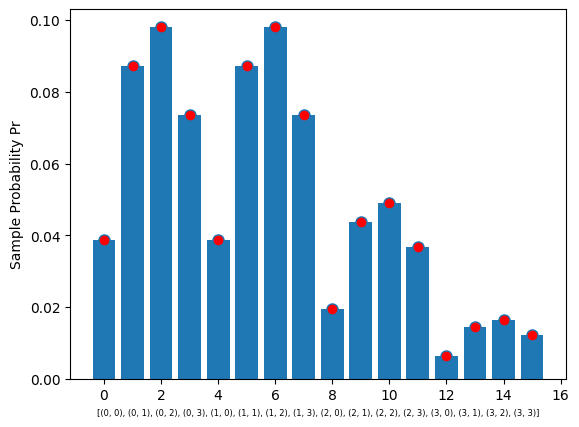

In [26]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=8, markerfacecolor='red', linestyle='none')
plt.xlabel(ln, fontsize=6);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample3.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots). Sampling patters are indicate in the labels.